In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load pretrained SD-XT model

import os

os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import torch
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video

pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16",
).to('cuda')
# From https://huggingface.co/docs/diffusers/main/en/using-diffusers/svd
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

2024-02-26 19:46:49.679656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
"""
I treat this as a video modeling problem.
The location of the end-effector is treated
as a probability distribution over the pixels
in the image.
"""

from text_and_image_conditioned_video_diffusion_model import VisualTrajectorySynthesizer
from transformers import CLIPTextModelWithProjection, CLIPProcessor

"""
>>> pipe.image_encoder

... width 1280 model. Most likely https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/model_configs/ViT-H-14.json,
which is OpenCLIP ViT-H-14 (32 layers, matches)

This is available here: https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K
"""

text_model = CLIPTextModelWithProjection.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K", torch_dtype=torch.float16).to(device='cuda')
clip_processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

In [4]:
syn = VisualTrajectorySynthesizer.from_stable_video_diffusion_pipeline(pipe, text_model)
syn.feature_extractor = clip_processor

In [5]:
# text_embeddings = syn._encode_text("Hello world!", 'cuda', 1, False)

import PIL.Image

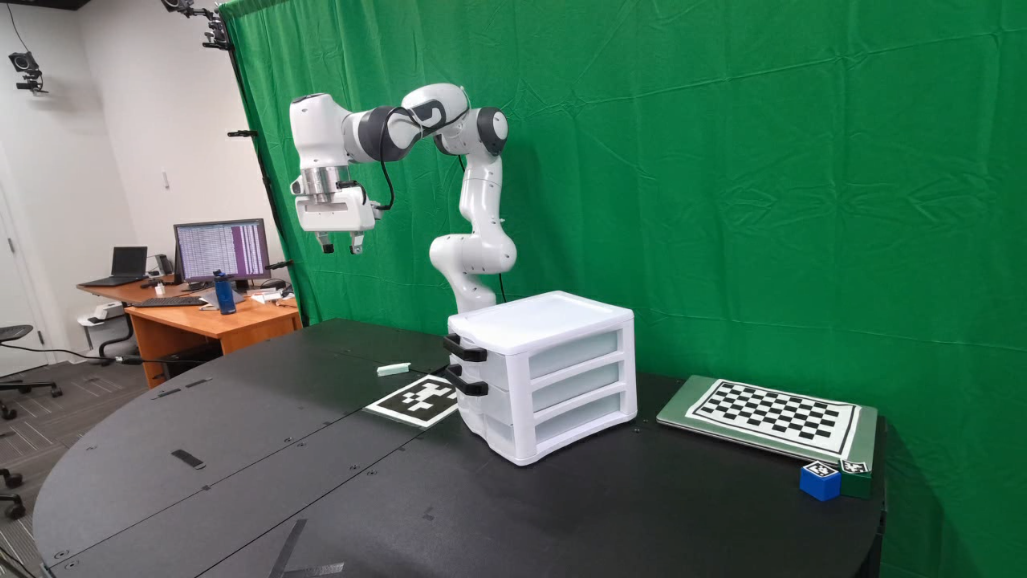

In [6]:
input_image = PIL.Image.open("../../initial_robotic_arm_image.png")
input_image

In [12]:
next(syn.image_encoder.parameters()).dtype == next(syn.text_encoder.parameters()).dtype

True

In [7]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [14]:
frames = syn.custom_call(input_image.convert("RGB"), "Franka Panda robotic arm grasps drawer handle smoothly", motion_bucket_id=0)

  0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
frames = syn.custom_call(input_image.convert("RGB"), "a drawer is opened", motion_bucket_id=0)

  0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
export_to_video(frames[0], "generated_text_conditioned_distractor_prompt.mp4", fps=7)

'generated_text_conditioned_distractor_prompt.mp4'

In [19]:
!ffmpeg -i generated_text_conditioned_distractor_prompt.mp4 generated_text_conditioned_distractor_prompt_converted.mp4 2>&1 | tqdm

0it [00:00, ?it/s]ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libope